# **Objective**


Several machine learning models are fit to a synthetic dataset of nine features to predict water potability in Kaggle task:

https://www.kaggle.com/adityakadiwal/water-potability



# **Notebook Contents**

- Feature correlation and distributions are considered. 

- Missing data is analyzed and imputed. 

- The data is resampled to decrease class imbalance. 

- A model spot search is done using scikit-learn. 

- A three layer neural network is implemented using PyTorch Lightning. 

- Hyperparameters are found using Ray Tune from a user defined search space. 

- Hyperparameters and their resulting model’s accuracy are visualized in an interactive parallel coordinates plot.

# Imports

## Library Imports

In [1]:
%%capture 

# Debugging
from pdb import set_trace as bp

# Download Water Quality dataset from Kaggle
!pip install opendatasets
import opendatasets as od

# Utility
import pandas as pd
import numpy as np
import random
from itertools import combinations
from tqdm import tqdm
import os
import json 

# Stats metrics
from scipy.stats import zscore, ks_2samp

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
!pip install beautifultable
from beautifultable import BeautifulTable
!pip install -U hiplot
import hiplot as hip
from IPython.display import Image

# Data over and under sampling
!pip install imbalanced-learn
import imblearn
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN 

# Split and preprocess data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# Scikit-learn models
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
# Scikit-learn metrics
from sklearn.metrics import precision_score,accuracy_score, roc_auc_score

# PyTorch (for neural network models and pipeline)
!pip install torch
!pip install pytorch_lightning
!pip install pytorch-metric-learning
!pip install ray[tune]
import torch as th 
import torchmetrics
import pytorch_lightning as pl
from pytorch_metric_learning import losses
from pytorch_lightning.callbacks import LearningRateMonitor
from ray import tune
from ray.tune.integration.pytorch_lightning import TuneReportCallback



## Dataset import

In [2]:
# download dataset
od.download("https://www.kaggle.com/adityakadiwal/water-potability")

# read dataset into data frame (need Kaggle account to create API Key)
df = pd.read_csv('/content/water-potability/water_potability.csv')


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: megankern
Your Kaggle Key: ··········


100%|██████████| 251k/251k [00:00<00:00, 37.8MB/s]

# Missing Values Analysis

In [3]:
# Missing values check


# Print dataset size
sample_count = df.shape[0]            # Get row count from data frame
print('Total Samples:', sample_count, '\n')

# Table of missing value counts
null_sample_count = df.isnull().sum()      # Make Boolean table for null values, count 'True' for each column
print('Missing Values:')
print(null_sample_count, '\n')

# Table of missing values as a percentage
null_sample_count_potability_1 = df.loc[df['Potability']==1].isnull().sum()             # Get rows with 'Potability'=1, count null values by column
null_sample_count_potability_0 = df.loc[df['Potability']==0].isnull().sum()             # Above but for 'Potability'=0

count_potability_1 = df.loc[df['Potability']==1].shape[0]                             # Count potable samples
count_potability_0 = df.loc[df['Potability']==0].shape[0]                             # Count non-potable samples
null_sample_ratio_potability_1 = null_sample_count_potability_1.apply( lambda x: (x/count_potability_1)*100 )   # Get ratio of null potable samples to total potable samples 
null_sample_ratio_potability_0 = null_sample_count_potability_0.apply( lambda x: (x/count_potability_0)*100 )   # Do above for non-potable                           
null_sample_ratio = null_sample_count.apply( lambda x: (x/sample_count)*100 )                        # Do above for whole dataset                               

drop_zero_columns = lambda df: df[df!=0]                                 # Define function to drop columns with only zero entries
null_sample_ratio_potability_1 = drop_zero_columns(null_sample_ratio_potability_1)    # Apply above function to data frame of: potable samples
null_sample_ratio_potability_0 = drop_zero_columns(null_sample_ratio_potability_0)    #                                       non-potable samples
null_sample_ratio          = drop_zero_columns(null_sample_ratio)             #                                               all data

for column in null_sample_ratio.index:  # Iterate through column headers of features in data with null samples
    print('Missing',column, 'data as a % of')
    print('All data         ', "{:.2f}".format(null_sample_ratio[column]))
    print('Potable Data     ', "{:.2f}".format(null_sample_ratio_potability_1[column]))
    print('Non-Potable Data ', "{:.2f}".format(null_sample_ratio_potability_0[column]),'\n')

# Class representation in dataset
print('Class representation:')
print(  round( (count_potability_1/sample_count)*100 ), '% potable data' )
print(  round( (count_potability_0/sample_count)*100 ), '% non-potable data', '\n' )

# Table counting multiple missing values in same sample
null_binary_df = df.isnull().astype(int)                    # Convert Boolean missing values table to 0/1 integers for samplewise sum operation
co_occurring_null = null_binary_df.sum(axis=1).value_counts()   # Samplewise sum operation
print('Number of samples with exactly 0, 1, 2, or 3 missing values:')
print(co_occurring_null, '\n')

columns_w_null = df.isnull().any()                # Get column names with null values
df_null = df.isnull().loc[:, columns_w_null]      # Boolean table for null values excluding columns/features with no null values
print('Effect of one null value on the presence of another (Pearson correlation):')
print( df_null.corr() , '\n')     

Total Samples: 3276 

Missing Values:
ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64 

Missing ph data as a % of
All data          14.99
Potable Data      13.85
Non-Potable Data  15.72 

Missing Sulfate data as a % of
All data          23.84
Potable Data      22.93
Non-Potable Data  24.42 

Missing Trihalomethanes data as a % of
All data          4.95
Potable Data      4.30
Non-Potable Data  5.36 

Class representation:
39 % potable data
61 % non-potable data 

Number of samples with exactly 0, 1, 2, or 3 missing values:
0    2011
1    1105
2     151
3       9
dtype: int64 

Effect of one null value on the presence of another (Pearson correlation):
                       ph   Sulfate  Trihalomethanes
ph               1.000000 -0.010144         0.006783
Sulfate         -0.010144  1.000000      

There are missing values. Most null values don't co-occur in the same sample. Too many to delete samples containing at least one missing value if it were decided they don't provide special value. The presence of one null value is not correlated to the presence of another.

Non-potable data has a bit higher percentage of missing values than potable.

The dataset does look complete enough to potentially use with ML algorithms.

# Feature Correlation Map

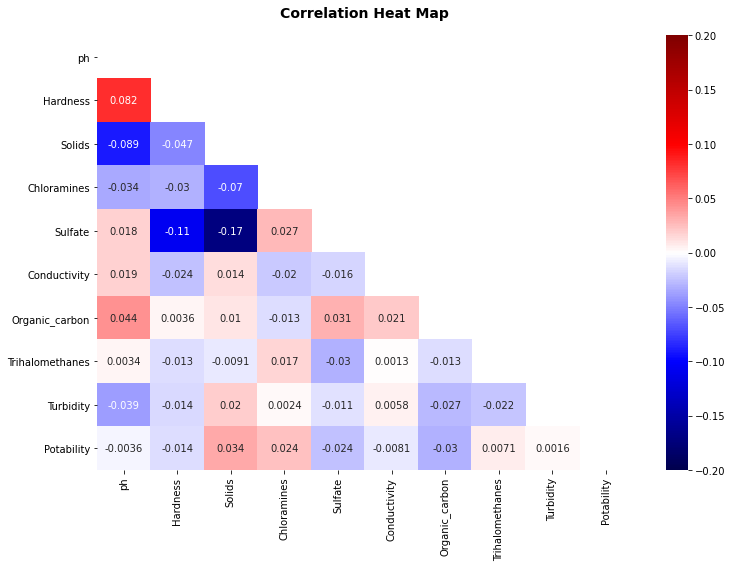

In [ ]:
# Feature correlation heat map


# Get Pearson correlation values
data = df.corr()    # Pairwise correlation with a null value is ignored

# Generate heat map using seaborn
fig, ax = plt.subplots(figsize=(12,8))                          # Create grid of empty subplots using matplotlib library                      
mask = np.triu(np.ones_like(data, dtype=bool))                   # Mask correlation matrix along its line of symmetry to remove redencency and correlation of a feature with itself
sns.heatmap(data, cmap='seismic', annot=True, mask=mask, ax=ax, vmin=-0.2, vmax=0.2)    # Create heat map useing seaborn library
fig.text(0.5, 1.05, 'Correlation Heat Map', horizontalalignment='center', verticalalignment='center', fontsize=14, fontweight='bold', transform=ax.transAxes)   # Add title
sns.set_style('white')        # Remove tick marks


The highest coefficient is -0.17, between sulfate and solids. This indicates low correlation between all features. No features are redundant but this will make imputing missing values harder as they can't be estimated by regressing on another feature. Deletion or replacement with the median will be used over more sophisticated methods such as Multiple Imputation by Chained Equations.

Additionally, none of these features individually are very correlated with the dependent variable, Potability.

# Feature Distribution Analysis

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

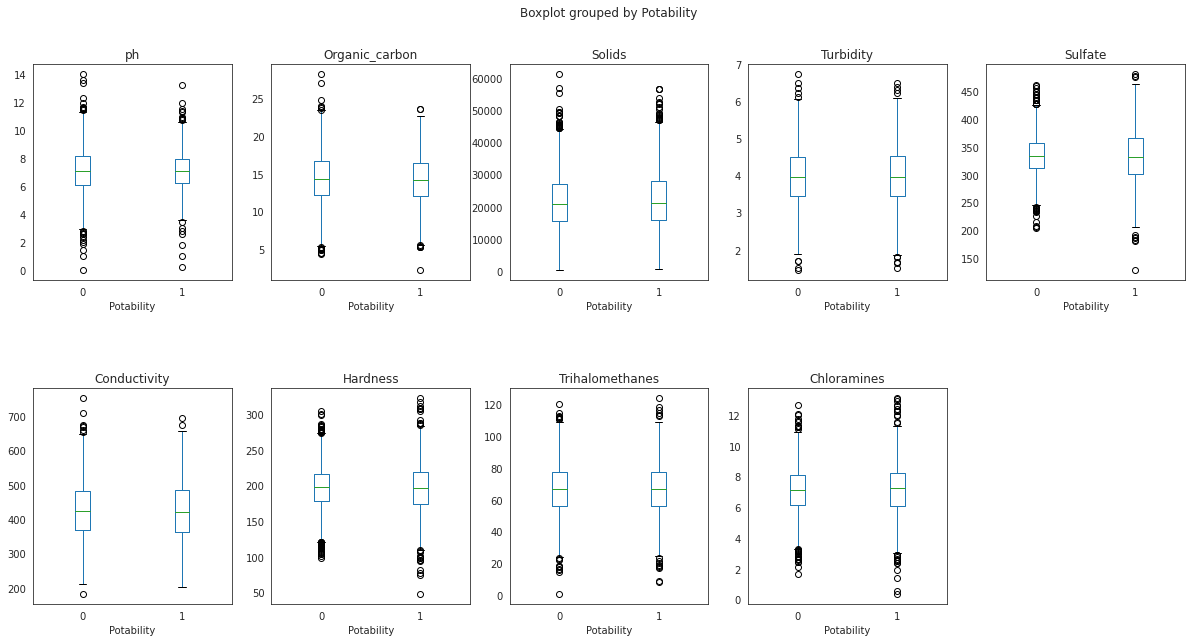

In [ ]:
# Box Plots


fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))  # Create empty grid of subplots
fig.subplots_adjust(hspace=.5)                       # Adjust vertical/height spacing 

# Fill each subplot with the distribution of a feature separated by potability
a=0                               # Increment subplot coordinates
for feature in df.drop('Potability', axis=1):    # Iterate through features ('Potability' is a label) 
  df.boxplot(by='Potability', column=[feature], ax=axes[ a%2, a%5 ], grid=False)    # Create boxplots for each feature grouped by potable or not (df.boxplot() auto handles nan correctly). Subplot coordinates [a%2, a%5] start top left and vertically zig zag moving right.
  a+=1

axes[1,4].remove()        # Remove unnecessary subplot from 2x5 grid
plt.show()

Data looks normally distributed with a few outliers.

In [4]:
# Compute Z-score for each distribution to quantify outliers

def score_summary(df):
  scores = df.apply(zscore, nan_policy='omit')                     # Compute zscore columnwise, omit null values
  outlier_count = scores[scores > 3.0].count()                     # Count all data over 3 deviations from the mean as outliers
  outlier_percent = ( outlier_count / df.count() )*100             # Get percent of non-null data considered an outlier featurewise
  return outlier_count, outlier_percent

df_potability_1 = df.loc[ df['Potability']==1 ].drop('Potability', axis=1)                   # Separate data out by class
df_potability_0 = df.loc[ df['Potability']==0 ].drop('Potability', axis=1)

df_potability_1_count   = score_summary(df_potability_1)[0]       # Get outlier count   featurewise for potable data
df_potability_1_percent = score_summary(df_potability_1)[1]       # Get outlier percent featurewise for potable data

df_potability_0_count   = score_summary(df_potability_0)[0]       # Get outlier count   featurewise for non-potable data
df_potability_0_percent = score_summary(df_potability_0)[1]       # Get outlier percent featurewise for non-potable data

table = BeautifulTable()    # Initialize BeautifulTable instance from 'beautifultable' library
table.columns.header = [ ' ',       'Outlier Count'+ '\n' + 'Potable',      'Outlier Count'+ '\n' + 'Non-Potable',   'Percent of Total'+ '\n' + 'Samples (%)'+ '\n' + 'Potable',   'Percent of Total'+ '\n' + 'Samples (%)'+ '\n' + 'Non-Potable']
for column in df.drop('Potability', axis=1):      # Iterate through features (drop class)
  table.rows.append(   [column,     df_potability_1_count[column],           df_potability_0_count[column],           df_potability_1_percent[column],                              df_potability_0_percent[column] ] )     # Append outlier summary information featurewise to table

table.set_style(BeautifulTable.STYLE_RST)   # Set BeautifulTable style 
table.columns.width = 20
table.columns.alignment = BeautifulTable.ALIGN_LEFT   # Left justify text
print(table)

==================== ==================== ==================== ==================== ====================
                      Outlier Count        Outlier Count        Percent of Total     Percent of Total   
                      Potable              Non-Potable          Samples (%)          Samples (%)        
                                                                Potable              Non-Potable        
==================== ==================== ==================== ==================== ====================
 ph                   3                    4                    0.272                0.238              
 Hardness             7                    3                    0.548                0.15               
 Solids               9                    11                   0.704                0.551              
 Chloramines          7                    4                    0.548                0.2                
 Sulfate              3                    6           

Outliers may be an important rare case in this dataset of only 9 features to predict water portability. However, creating a separate model to handle these cases may be hard with the number of outliers.

# Train/Test Split

In [ ]:
# Split train/test

print('Whole data frame shape:', df.shape, '\n')

df_y = df['Potability']                                                     # Create data frame for only data labels 
df_x = df.drop('Potability', axis=1)                                                # Create data frame for only data features

train_x, test_x, train_y, test_y = train_test_split(df_x, df_y, stratify=df_y, test_size=0.2, random_state=1)        # Split dataset 20% test, 80% train. Stratify 'Potability'.

train = pd.concat([train_x, train_y], axis=1)       # Recombine features and label into one data frame
test  = pd.concat([test_x,  test_y ], axis=1)

print('Train data frame shape:', train.shape)
print('Test data frame shape:', test.shape)
print('All rows accounted for:', train.shape[0] + test.shape[0] == df.shape[0] , '\n')


Whole dataframe shape: (3276, 10) 

Train dataframe shape: (2620, 10)
Test dataframe shape: (656, 10)
All rows accounted for: True 



# Handle Missing Values

Difference in featurewise medians between potable and non potable samples in train data:
ph                 0.020090
Sulfate           -1.545250
Trihalomethanes    0.504667
dtype: float64


Feature distributions in train dataset:



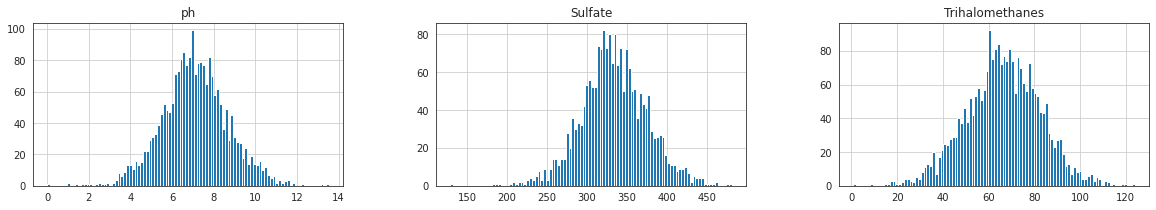


Median values in train data:
ph                   7.042230
Sulfate            332.349949
Trihalomethanes     66.270477
dtype: float64


In [ ]:
# Consider imputing missing values with median

print('Difference in featurewise medians between potable and non-potable samples in train data:')
print(  ( train[train['Potability']==1].median() - train[train['Potability']==0].median() ) [df.isnull().any()]  )    # Of potable samples, find featurewise medians. Do same for Non-potable samples. Subtract the difference. Drop features with no null values. 


def hist_features_w_null(df, subset):
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,3))      # Create empty figure with three subplots
  features = df.columns[df.isnull().any()]                        # Get list of features with null values
  for i in range(len(features)):                                  # Iterate through range that will index axis location of subplot and feature within features iterable
    subset.hist(features[i], bins=100, ax=axes[i])                 # Plot histogram using pandas extension of matplotlib
  plt.show()

print('\n\n' + 'Feature distributions in train dataset:'+ '\n')
hist_features_w_null(df, train)

print('\n' + 'Median values in train data:')
print( train.median()[df.isnull().any()] )

The median of a feature with null samples is similar between potable and non-potable groups. The differences in median value don't represent large movement on their respective feature histograms. Median imputation will fill null values since this does not affect feature distributions much.


In [ ]:
# Impute missing values
train_median = train.median()                                    # Find each columns median value in train set
for feature in df.drop('Potability', axis=1):                            # For feature in original data frame
  train[feature].fillna(train_median[feature], inplace = True)   # Replace missing values in a feature's data with its respective median value (found on train data to prevent data leakage)
  test[feature].fillna( train_median[feature], inplace = True)




Feature distributions in train dataset:



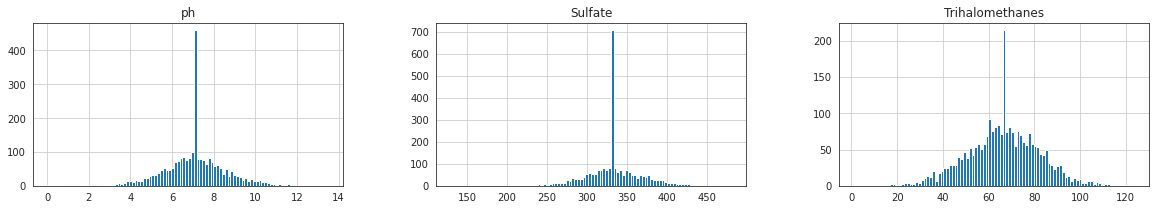



Feature distributions in test dataset:



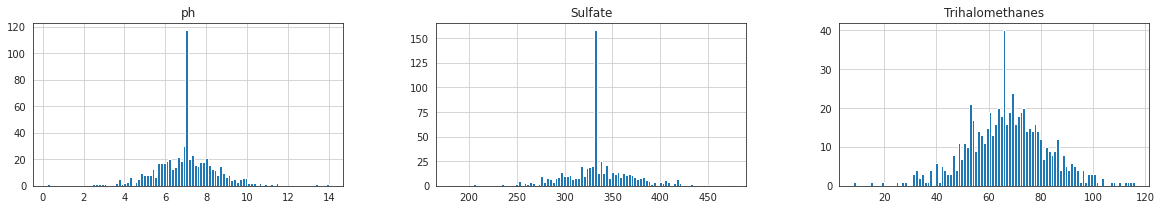

In [ ]:
# Plot histograms of features after imputing

print('\n\n' + 'Feature distributions in train dataset:'+ '\n')
hist_features_w_null(df, train)

print('\n\n' + 'Feature distributions in test dataset:'+ '\n')
hist_features_w_null(df, test)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

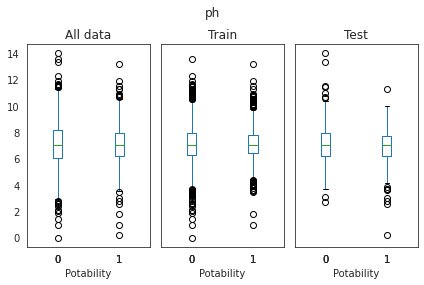

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

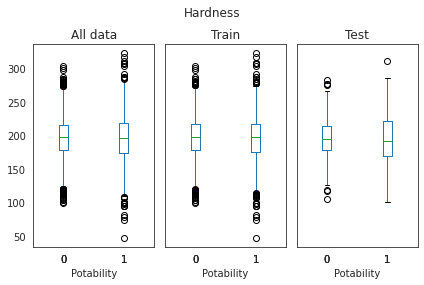

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

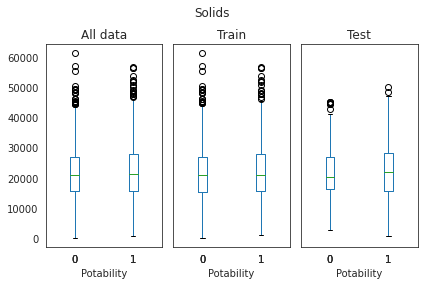

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

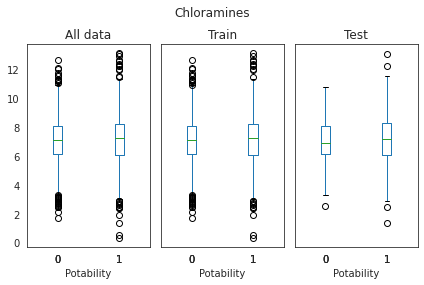

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

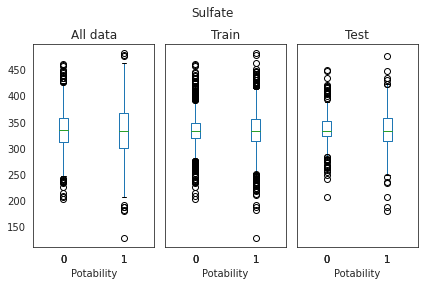

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

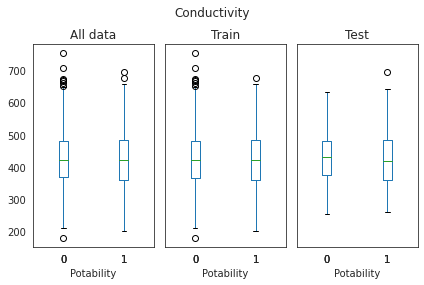

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

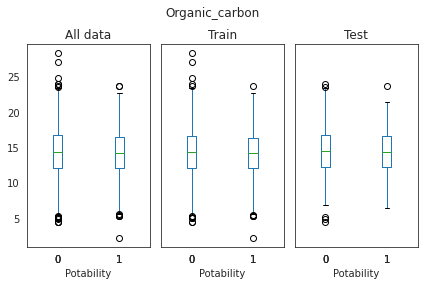

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

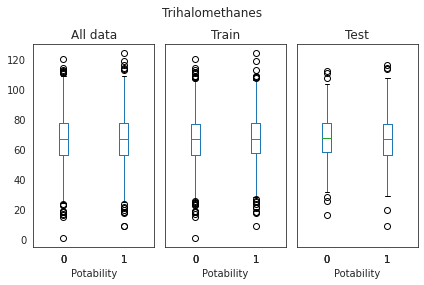

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

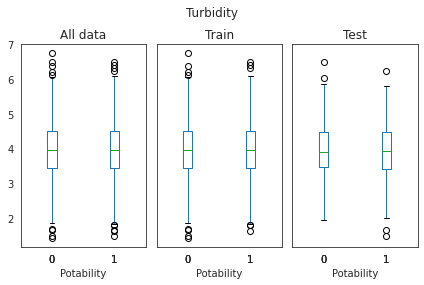

In [ ]:
# Box plot original data, train data, and test data after imputing missing values

for feature in df.drop('Potability', axis=1):                                 # For feature in data
  fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True)        # Create three empty subplots
  df.boxplot(by='Potability', column=[feature], ax=axes[0], grid=False).set_title('All data')   # Boxplot original data
  train.boxplot(by='Potability', column=[feature], ax=axes[1], grid=False).set_title('Train')   # Boxplot train set
  test.boxplot(by='Potability', column=[feature], ax=axes[2], grid=False).set_title('Test')     # Boxplot test set
  fig.suptitle(feature)               # Title overall figure the feature name
  fig.tight_layout()
  plt.subplots_adjust(top=0.85)
  plt.show()

All distributions remain approximately the same. The mean of sulfate's non-potable test set is a bit low, skewing its distribution to the right. Sulfate had the most data missing at 23.84%

# Resample To Balance Classes

In [ ]:
# SMOTE over sampling and Tomek links under sampling to let the model better focus the potable class

# Print counts before resampling
print('Potable sample count by feature')
print(train[train['Potability']==1].count())
print('\n'+'Non-Potable sample count by feature')
print(train[train['Potability']==0].count())


# Separate out features from label
train_x = train.drop('Potability', axis=1)
train_y = train['Potability']

# Preform over and under sampling using imbalanced-learn library
sm = SMOTETomek(random_state=42, sampling_strategy=0.8)       # sampling_strategy = ratio of minority class to majority class after resampling
train_x, train_y = sm.fit_resample(train_x, train_y)

# Get train data back into pandas data frame and recombine labels with features
train_x = pd.DataFrame(train_x, columns=df.drop('Potability', axis=1).columns)    # Get corresponding column names from original data frame
train_y = pd.DataFrame(train_y, columns=['Potability'])
train = pd.concat([train_x, train_y], axis=1)


# Print counts after resampling
print('\n\n'+'After SMOTE over sampling and Tomek links under sampling')
print('\n'+'Potable sample count by feature')
print(train[train['Potability']==1].count())
print('\n'+'Non-Potable sample count by feature')
print(train[train['Potability']==0].count())


Potable sample count by feature
ph                 1022
Hardness           1022
Solids             1022
Chloramines        1022
Sulfate            1022
Conductivity       1022
Organic_carbon     1022
Trihalomethanes    1022
Turbidity          1022
Potability         1022
dtype: int64

Non Potable sample count by feature
ph                 1598
Hardness           1598
Solids             1598
Chloramines        1598
Sulfate            1598
Conductivity       1598
Organic_carbon     1598
Trihalomethanes    1598
Turbidity          1598
Potability         1598
dtype: int64


After SMOTE over sampling and Tomek links under sampling

Potable sample count by feature
ph                 1039
Hardness           1039
Solids             1039
Chloramines        1039
Sulfate            1039
Conductivity       1039
Organic_carbon     1039
Trihalomethanes    1039
Turbidity          1039
Potability         1039
dtype: int64

Non-Potable sample count by feature
ph                 1359
Hardness           

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# Standardize Data

In [ ]:
# Normalize and zero mean train and test set

# Separate out features from labels for train and test sets
train_x = train.drop('Potability', axis = 1)
test_x  = test.drop('Potability', axis = 1)
train_y = train['Potability']
test_y  = test['Potability']

scaler = StandardScaler()
scaler.fit(train_x)                     # Fit scaler to train data
train_x = scaler.transform(train_x)     # Transform train data with scaler fit on train data
test_x  = scaler.transform(test_x)      # Transform test  data with scaler fit on train data

In [ ]:
# Class imbalance in train and test sets

# Train set class imbalance
print('Train set (Resampled)')
print( 'Percent Potable    ', round((train_y[train_y==1].count() / train_y.shape[0])*100) ) # Use separate label data frame to count potable samples and divide by total. Multiply by 100 to get percentage then round.
print( 'Percent Non-Potable', round((train_y[train_y==0].count() / train_y.shape[0])*100) ) # Same as above but count non-potable this time

# Test set class imbalance
print('\n'+'Test set ')
print( 'Percent Potable    ', round((test_y[test_y==1].count() / test_y.shape[0])*100) )
print( 'Percent Non-Potable', round((test_y[test_y==0].count() / test_y.shape[0])*100) )

Train set (Resampled)
Percent Potable     43
Percent Non Potable 57

Test set 
Percent Potable     39
Percent Non Potable 61


# Models

## sklearn Models 

In [ ]:
models = [  
  LogisticRegression(),
  SVC(),
  KNeighborsClassifier(),
  DecisionTreeClassifier(),
  GaussianNB(),
  RandomForestClassifier(),
  AdaBoostClassifier(),
  GradientBoostingClassifier(),
  MLPClassifier()   
  ]


for model in models:
  model = model
  model.fit(train_x, train_y)
  model_results = model.predict(test_x)
  precision = precision_score(test_y, model_results,average='macro')
  roc_auc = roc_auc_score(test_y, model_results,average='macro')
  acc = accuracy_score(test_y, model_results)

  print('\n\n\n'+'________________________________________________________________________________________'+'\n\n\n')
  print(model)
  print('\n')
  print('Precision                                ', precision)
  print('Receiver Operating Characteristic Curve  ', roc_auc)
  print('Accuracy                                 ', acc)




________________________________________________________________________________________



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Precision                                 0.8058103975535168
Receiver Operating Characteristic Curve   0.50390625
Accuracy                                  0.6128048780487805



________________________________________________________________________________________



SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


Precision                                 0.70989270531

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Note the train set was resampled so its class imbalance is 43% potable, 57% non-potable. The test set was not resampled, it retains a class imbalance of 39% potable,
61% non-potable. So if a model only guessed non-potable it would have 61% accuracy. Precision and area under the ROC curve are used to evaluate performance alongside accuracy. 

Logistic Regression's accuracy is the closest to the test set's percent of non-potable data. This is consistent with an area under the ROC curve of 0.5, the lowest predictive power. Logistic Regression had a precision score of 80% showing precision alone is not always a good substitute for accuracy on an imbalanced dataset.

Support vector classifier did the best at 70.6% accuracy, 71.0% precision, and 0.65 area under ROC curve. The data must be somewhat linearly separable by class.

## PyTorch Lightning Model

In [ ]:
# Data Prep


def prepare_data(features, labels):
  dataset = []
  for index in zip(features, labels):               # Loop through the feature and label data frames while matching their indices  
    input = th.Tensor(index[0])                  # Convert the feature vector to the Tensor type default; floating point
    label = th.tensor(index[1])                  # Convert the label vector to a tensor type inferred from integer data
    dataset.append( {'input': input, 'label': label} )    # Append to running list in record format
  return dataset

train = prepare_data(train_x, train_y)              # Call above function on train dataset (which has been split into feature and label data frames for the sklearn models)
test = prepare_data(test_x, test_y)               # Call above function to preprocess test set

In [ ]:
# Model

%reload_ext tensorboard
%tensorboard --logdir drive/MyDrive/Water_Potability/train_model --port 6006      # Specifying the port sometimes prevents an error keeping tensorboard from appearing


class PotableWaterClassifier(pl.LightningModule):
  def __init__(self, config, train_ds, val_ds):                                 # PyTorch lightning model is wrapped with Ray Tune, so Ray Tune's config file and train/val data are passed to __init__
    super().__init__()
 
    self.lr = config["lr"]             # Learning rate, batch size, and layer sizes are all picked from Ray Tune's defined search space then passed to the class instance 
    self.batch_size = config["batch_size"]
    layer_1, layer_2, layer_3 = config["layer_1"], config["layer_2"], config["layer_3"]
 
    self.layer_1 = th.nn.Linear(9, layer_1)                     # Input has 9 features
    self.layer_2 = th.nn.Linear(  layer_1, layer_2)
    self.layer_3 = th.nn.Linear(        layer_2, layer_3)
    self.layer_4 = th.nn.Linear(              layer_3, 2)       # Two output neurons for the binary potable/non-potable classification

    self.accuracy = torchmetrics.Accuracy()
    self.loss = th.nn.CrossEntropyLoss()        # CrossEntropyLoss class defined here to be used with softmax function defined in final layer of forward method
    self.train_ds = train_ds
    self.val_ds = val_ds
    
  def forward(self, x):           # x = one batch of shape: (batch size, input feature number)
    x = self.layer_1(x)          
    x = th.nn.functional.elu_(x)    # ELU activation is used after each layer until final layer which uses a softmax
    x = self.layer_2(x)
    x = th.nn.functional.elu_(x)
    x = self.layer_3(x)
    x = th.nn.functional.softmax(x, dim=1)  # x.shape = (batch size, layer size) so softmax is applied along layer dimension (dim=1)
    return x

  def configure_optimizers(self):
    optimizer = th.optim.AdamW( self.parameters(), lr = self.lr )
    scheduler = th.optim.lr_scheduler.ReduceLROnPlateau( optimizer, patience = 1 )    # Patience sets number of epochs with no improvement to reduce learning rate, default threshold for improvement: threshold=0.0001
    return {
          'optimizer': optimizer,
          'lr_scheduler': scheduler,
          'monitor': 'ptl/train_loss'     # 'monitor' is the metric 'lr_scheduler' evaluates before changing the learning rate
      }

  def training_step(self, batch, batch_idx):  # Batch is a list of records with ids: 'input' and 'label'
    logits = self.forward(batch['input'])     # Get forward pass using batch of inputs
    loss  = self.loss(logits, batch['label'])   # Calculate loss from batch of model outputs and their labels
    self.log('ptl/train_loss', loss)          # Log loss for the learning rate scheduler to monitor 
    return loss

  def validation_step(self, batch, batch_idx):    # The entire test/val set is passed as one batch
    logits = self.forward(batch['input'])        
    acc  = self.accuracy(logits, batch['label'])
    self.log('ptl/val_accuracy', acc)           # Log test/val accuracy for Ray Tune to decide what epoch to abandon trial

  def train_dataloader(self):
    return th.utils.data.DataLoader(
        self.train_ds,
        batch_size = self.batch_size,
        drop_last = True,
        shuffle = True,
    )

  def val_dataloader(self):
    return th.utils.data.DataLoader(
        self.val_ds,
        batch_size = len(self.val_ds),    # Send entire test/val set to validation_step in one batch
        drop_last = False,
        shuffle = False,
    )

def train_model(config, num_epochs, train_ds, val_ds):
  model = PotableWaterClassifier(config, train_ds, val_ds)     # Create model instance with Ray Tune config file, train data, and test/val data
  metrics = {'acc': 'ptl/val_accuracy'}                    # Define metrics to pass to Ray Tune callback so it can stop trails early
  trainer = pl.Trainer(
      progress_bar_refresh_rate=0,                          # Make the output cleaner
      callbacks=[TuneReportCallback(metrics, on='validation_end')],    # Report PyTorch lightning metrics to Ray Tune
      max_epochs = num_epochs,                          # Max number of epochs to run a trial
      gpus = (1 if th.cuda.is_available() else 0),
      )
  trainer.fit(model)

num_trials = 4000
epochs = 30

# Define hyperparameter search space
config = {                                    
    'layer_1': tune.choice( list(range(2,200,2)) ),
    'layer_2': tune.choice( list(range(2,200,2)) ),
    'layer_3': tune.choice( list(range(2,200,2)) ),
    'lr': tune.loguniform(0.00001, 0.001),
    'batch_size': tune.choice( list(range(20,500,20)) ),
}

# Ray Tune wrapper for PyTorch lightning
trainable = tune.with_parameters(     
    train_model,                 # Pass train_model() function
    num_epochs=epochs,           # Everything else is passed to train_model()
    train_ds=train,               
    val_ds=test
    )

analysis = tune.run(
    trainable,
    resources_per_trial={ 'cpu': 1, 'gpu': (1 if th.cuda.is_available() else 0), },
    metric='acc',        # Abandon trial based on accuracy 
    mode='max',        # Maximize metric defined above
    config=config,
    num_samples=num_trials,
    name='train_model',       # Name folder created in local_dir to store Ray Tune and PyTorch lightning output
    local_dir = 'drive/MyDrive/Water_Potability/',
    )

In [ ]:
# Hyperparameter visualization

model_logs = [entry for entry in os.listdir('drive/MyDrive/Water_Potability/train_model/') if entry[:11]=='train_model']    # Get Ray Tune output file names

plt_data = []                   # Data to be plotted in parallel coordinates graph
for model_log in tqdm(model_logs):   # For Ray Tune trial
  path = 'drive/MyDrive/Water_Potability/train_model/' + model_log + '/result.json'   # Get file path of trial result  
  f = open(path)
  if os.path.getsize(path) != 0:          # If trial result is not empty
    result = json.loads(f.readlines()[-1])    # Load data from the last epoch reached
    info = result['config']             # Get trial hyperparameters (returns dictionary)
    info['acc'] = result['acc']           # Add 'accuracy' key to info and assign trial accuracy
    plt_data.append(info)             # Append trial to list of trials to be plotted

hip.Experiment.from_iterable(plt_data).display()    # Create parallel coordinates graph using HiPlot library from Facebook

Output hidden; open in https://colab.research.google.com to view.

The highest accuracy achieved is 68%. The test set has a class imbalance of 61% non-potable to 39% potable, so the best model beats a model only choosing non-potable by seven points. Additional metrics were not calculated but would help interpretation of results. For reference, accuracy in the Scikit-learn MLPClassifier is two points above its 65% precision. 

The lowest accuracy models mostly have an initial learning rate below 1e-4. Batch sizes tend to be over 250. The training set has 1620 examples making batch sizes over 250 split the data six ways at the most.

In [ ]:
Image('drive/MyDrive/Water_Potability/images/low_acc.PNG')

Output hidden; open in https://colab.research.google.com to view.

The highest accuracy models use initial learning rates mostly between 1e-4 and 1e-3. Batch sizes are mostly under 250.

In [ ]:
Image('drive/MyDrive/Water_Potability/images/high_acc.PNG')

Output hidden; open in https://colab.research.google.com to view.

As a network gets deeper, decreasing layer size encourages gradual consolidation of information down to the decision point. Making a network wider with depth encourages extrapolation to erroneous details which could amplify noise and cause overfitting. Here, models that expanded width with depth actually achieved high and low accuracy in similar numbers. However, less models that decreased layer size with depth had low accuracy rather than high.

In [ ]:
Image('drive/MyDrive/Water_Potability/images/increasing_layers.PNG')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
Image('drive/MyDrive/Water_Potability/images/decreasing_layers.PNG')

Output hidden; open in https://colab.research.google.com to view.

Top three models:

| layer_1 | layer_2 | layer_3 | lr | batch_size | acc |
| --- | --- | --- | --- | --- | --- |
| 80 | 106 | 2 | 0.0007332761721359008 | 60 | 0.6844512224197388 |
| 184 | 128 | 78 | 0.0005416626161799641 | 340 | 0.6615853905677795 |
| 170 | 188 | 198 | 0.0005559121098672098 | 100 | 0.6631097793579102 |

It would be interesting to train neural networks on data already shown to allow prediction with high accuracy and take more samples from the hyperparameter search space. Additionally, the success or failure of models under different configurations could be quantified to aid the visual representation.